# Programming Exercise 3.2: Multi-class Classification and Neural Networks (Backpropagation is used)

# 1. Loading Data

In [234]:
import numpy as np
import matplotlib.pyplot as pyplot

In [235]:
import scipy.io as sio
data = sio.loadmat('ex3data1.mat')

In [344]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]], dtype=uint8)}

In [237]:
x = data['X'] #input data

In [238]:
X = np.insert(x, 0, 1, axis = 1) #augmented with one input data

In [239]:
Y = data['y'] #output data (labels)

# 2. Visualizing Data 

### 2.1 First Method of Visualization

In [240]:
#For visualization the code for converting these 400 pixels into image is found in Github

In [241]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [242]:
#Let us take random choices to show the inputs
m = 5000 #number of samples
rand_choices = np.random.choice(m, size = 100, replace = True)

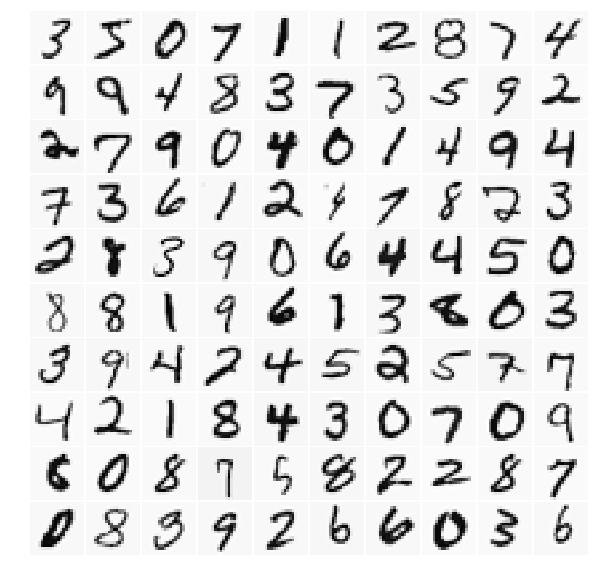

In [243]:
#it is important to give as an argument not-augmented x
displayData(x[rand_choices, :])

### 2.2 Second method of visualization

The code is taken from https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-neural-networks-e526b41fdcd9

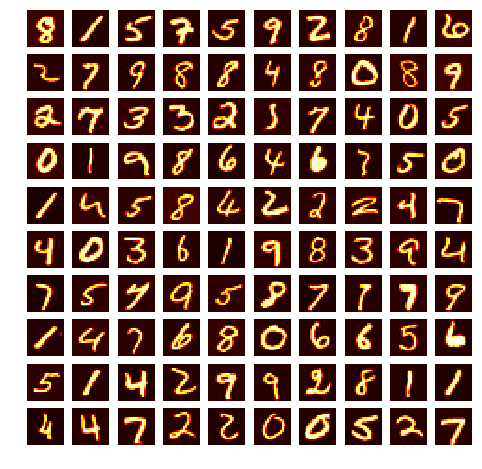

In [345]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(x[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")

# 3. Feedforward

    The architecture of the neural network:
    Shapes:
     - X.shape = (5000, 400)
     - Y.shape = (5000, 1)
     - Theta1.shape = (25, 401)
     - Theta2.shape = (10, 26)
<img src = "neuralnetwork.png">

In [244]:
#importing my in-advance written functions for sigmoid, cost, GDS
import basicFuncs as bf

            It is necessary to initialize weights. To initialize randomly is very important otherwise the activation functions of the same layer won't change in any number of iterations; while neural net wants to have different functions covered by activations (neurons).

In [245]:
#Initializing weights randomly for Backpropagation
Theta1 = np.random.random((25, 401))
Theta2 = np.random.random((10, 26))

In [246]:
#Pre-defined weights for checking the cost
Weights = sio.loadmat('ex3weights.mat')
Weight1, Weight2 = Weights['Theta1'], Weights['Theta2']

In [247]:
def feedforward(x, theta1, theta2):
    a0 = x
    z1 = a0 @ theta1.T
    a1 = bf.sigmoid(x, theta1.T)
    a1_aug = np.insert(a1, 0, 1, axis = 1)
    z2 = a1_aug @ theta2.T
    a2 = bf.sigmoid(a1_aug, theta2.T)
    return a2

In [248]:
H = feedforward(X, Weight1, Weight2)

### 3.1 Results with random weights

In [249]:
np.set_printoptions(suppress=True)

In [250]:
H[0]

array([0.00011266, 0.00174128, 0.00252697, 0.0000184 , 0.00936264,
       0.0039927 , 0.00551518, 0.00040147, 0.00648072, 0.99573401])

        We need to take the index of the highest value in each row of the output a2 and to compare them with Y.

In [251]:
h = []
for i in range(m):
    each_row = H[i]
    max_value = 0.0
    index_of_max_value = 0
    for j in range(len(each_row)):
        if each_row[j] > max_value:
            max_value = each_row[j]
            index_of_max_value = j
    h.append(index_of_max_value + 1) #we add 1 because indexation in Octave starts with 1
    #in the given dataset in Y index 10 stands for 0

In [252]:
len(h)

5000

            We need to convert h to np array, but since Y.shape is (5000,1), instead of np.array(h), it has been done np.array([h]).

In [253]:
h_matrix = np.array([h])

In [254]:
h_matrix.shape

(1, 5000)

In [255]:
H = h_matrix.T

In [256]:
H.shape

(5000, 1)

In [257]:
Y.shape

(5000, 1)

        Accuracy with random weights is 10%.

In [258]:
np.mean(H == Y) * 100

97.52

# 4. Cost Function

        It is necessary to write the regularized cost function for neural network given by Andrew NG:
<img src = "cost_nn.png">

        To see the correctness of the written code for the cost, it has been download found weight values and calculated cost. It should be about 0.383770 at lambda=1.

### 4.2.1 One Hot Encoding

        Before applying one hot encoding, it is necessary to change the places where Y and H equal to 10 to 0. Otherwise, there is an 'index 10 is out of bounds for axis 1 with size 10' error.

In [279]:
Y[Y[:] == 10] = 0
H[H[:] == 10] = 0

In [280]:
from keras.utils.np_utils import to_categorical   

Y_encoded = to_categorical(Y, num_classes=10)
H_encoded = to_categorical(H, num_classes=10)

In [281]:
Y_encoded.shape

(5000, 10)

In [282]:
H_encoded.shape

(5000, 10)

In [319]:
h_e = H_encoded
mask = H_encoded==0
h_e[mask] = h_e[mask]+ 1e-6

y_e = Y_encoded
mask = Y_encoded==0
y_e[mask] = y_e[mask]+ 1e-6

In [320]:
h_e = H_encoded
mask = H_encoded==1
h_e[mask] = h_e[mask]- 1e-6

y_e = Y_encoded
mask = Y_encoded==1
y_e[mask] = y_e[mask]- 1e-6

In [338]:
(y_e @ h_e.T).shape

(5000, 5000)

In [339]:
y_e.T[0]

array([0.999999  , 0.999999  , 0.999999  , ..., 0.00000001, 0.00000001,
       0.00000001], dtype=float32)

In [346]:
def cost(h, theta1, theta2, y, lamb):
    """
    x.shape should be (n,m)
    theta.shape should be (n,1)
    y.shape should be (m,1)
    """
    #h = sigmoid(x, theta)
    error = np.sum(y.T @ np.log(h) + (1-y).T @ np.log(1-h))
    ca = (-1/m) * error

    Reg_term = lamb/(2*m) * (np.sum(theta1 ** 2) + np.sum(theta2 ** 2))
    return ca + Reg_term

In [347]:
cost(h_e, Weight1, Weight2, y_e, 1)

290.1036586310816

### HERE WHERE YOU ARE
refer to https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-neural-networks-e526b41fdcd9
and https://medium.com/deep-math-machine-learning-ai/chapter-7-artificial-neural-networks-with-math-bb711169481b

In [333]:
np.sum(a)

290.00684

In [334]:
m

5000

# 5. Backpropagation implementation

        Cheetsheet for Backpropagation taken from https://medium.com/deep-math-machine-learning-ai/chapter-7-artificial-neural-networks-with-math-bb711169481b

<img src="Backpropagation.jpeg">